# Тестовое задание Доктор 24

**Задача**: создать прогностическую модель рисков беременных.  
**Срок**: до 1 недели  
**Метрика**: решаете сами  
**Как сдавать**: ссылку на google colab с выводами. Обязательно вывести матрицу ошибок на тесте.  
**Особенности**: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.  


Описание:
 - `Age`: Age in years when a woman is pregnant.   
 - `SystolicBP`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.   
 - `DiastolicBP`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
 - `BS`: Blood glucose levels is in terms of a molar concentration, mmol/L.
 - `HeartRate`: A normal resting heart rate in beats per minute.
 - `Risk Level`: Predicted Risk Intensity Level during pregnancy considering the previous attribute.


**Рекомендации по выбору метрики для детекции сердечных приступов и как понять какая метрика нам в итоге нужна (базовые рассуждения)**

Приоритизация полноты (Recall):

Пропуск случаев сердечного приступа может иметь серьезные последствия, поэтому минимизация ложных отрицаний важна.

Баланс между точностью и полнотой (F1-Score):

Для балансировки между минимизацией ложных срабатываний и ложных отрицаний можно использовать F1-Score.

Использование матрицы ошибок (Confusion Matrix):

Оно нам нужно для понимания, какие классы наиболее проблематичны, и анализа, где происходят ошибки.


In [6]:
# pip install catboost
# pip install optuna
# pip install xgboost
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
from tqdm.notebook import trange, tqdm

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Загрузим датасет
file_path = '~/Projects/Доктор_24/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

In [9]:
class_counts = data['RiskLevel'].value_counts()
print(class_counts)

# Коэффициент дисбаланса 
imbalance_ratio = class_counts.max() / class_counts.min()
print(f'Коэффициент дисбаланса: {imbalance_ratio:.2f}')

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64
Коэффициент дисбаланса: 1.49


Коэффициент дисбаланса 1.49,это хорошее распределение коэффициэнтов, балансировку производить нет смысла.

In [11]:
# Закодировать целевую переменую
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])

In [12]:
# Добавление дополнительных фич
# в этом примере добавим старородящих и матерей-тинэйджеров
data['OldBirth'] = np.where(data['Age'] > 40, 1, 0)
data['EarlyBirth'] = np.where(data['Age'] < 20, 1, 0)

# Разделение данных на признаки и целевую переменную
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

In [19]:
# разделить на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Всем модели для обучения
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [22]:
# Обучить все модели
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)

    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Get the classification report and confusion matrix for train set
    train_report = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
    train_matrix = confusion_matrix(y_train, y_train_pred)

    # Get the classification report and confusion matrix for test set
    test_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
    test_matrix = confusion_matrix(y_test, y_test_pred)

    results[name] = {
        'model': model,
        'train_report': train_report,
        'train_matrix': train_matrix,
        'test_report': test_report,
        'test_matrix': test_matrix,
        'test_accuracy': accuracy_score(y_test, y_test_pred)
    }


In [26]:
print(f'Логистическая регрессия - y_test:\n{y_test.value_counts()}')
print(f'Логистическая регрессия - y_test_pred:\n{pd.Series(y_test_pred).value_counts()}')
print(f'Логистическая регрессия - тестовая матрица неточностей:\n{test_matrix}')

Логистическая регрессия - y_test:
RiskLevel
1    80
2    76
0    47
Name: count, dtype: int64
Логистическая регрессия - y_test_pred:
2    79
1    76
0    48
Name: count, dtype: int64
Логистическая регрессия - тестовая матрица неточностей:
[[41  1  5]
 [ 4 66 10]
 [ 3  9 64]]


In [30]:
for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get the classification report and confusion matrix for train set
    train_report = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
    train_matrix = confusion_matrix(y_train, y_train_pred)
    
    # Get the classification report and confusion matrix for test set
    test_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
    test_matrix = confusion_matrix(y_test, y_test_pred)
    
    results[name] = {
        'model': model,
        'train_report': train_report,
        'train_matrix': train_matrix,
        'test_report': test_report,
        'test_matrix': test_matrix,
        'test_accuracy': accuracy_score(y_test, y_test_pred)
    }
    
    if name == 'Logistic Regression':
        print(f'Логистическая регрессия - данные в словаре results:\n{results[name]}')

Логистическая регрессия - данные в словаре results:
{'model': LogisticRegression(max_iter=1000), 'train_report': {'high risk': {'precision': 0.8358974358974359, 'recall': 0.7244444444444444, 'f1-score': 0.7761904761904762, 'support': 225.0}, 'low risk': {'precision': 0.6039823008849557, 'recall': 0.8374233128834356, 'f1-score': 0.7017994858611826, 'support': 326.0}, 'mid risk': {'precision': 0.573170731707317, 'recall': 0.36153846153846153, 'f1-score': 0.44339622641509435, 'support': 260.0}, 'accuracy': 0.6535141800246609, 'macro avg': {'precision': 0.6710168228299028, 'recall': 0.6411354062887805, 'f1-score': 0.640462062822251, 'support': 811.0}, 'weighted avg': {'precision': 0.6584457995182751, 'recall': 0.6535141800246609, 'f1-score': 0.639596187918036, 'support': 811.0}}, 'train_matrix': array([[163,  39,  23],
       [  6, 273,  47],
       [ 26, 140,  94]]), 'test_report': {'high risk': {'precision': 0.8095238095238095, 'recall': 0.723404255319149, 'f1-score': 0.7640449438202247,

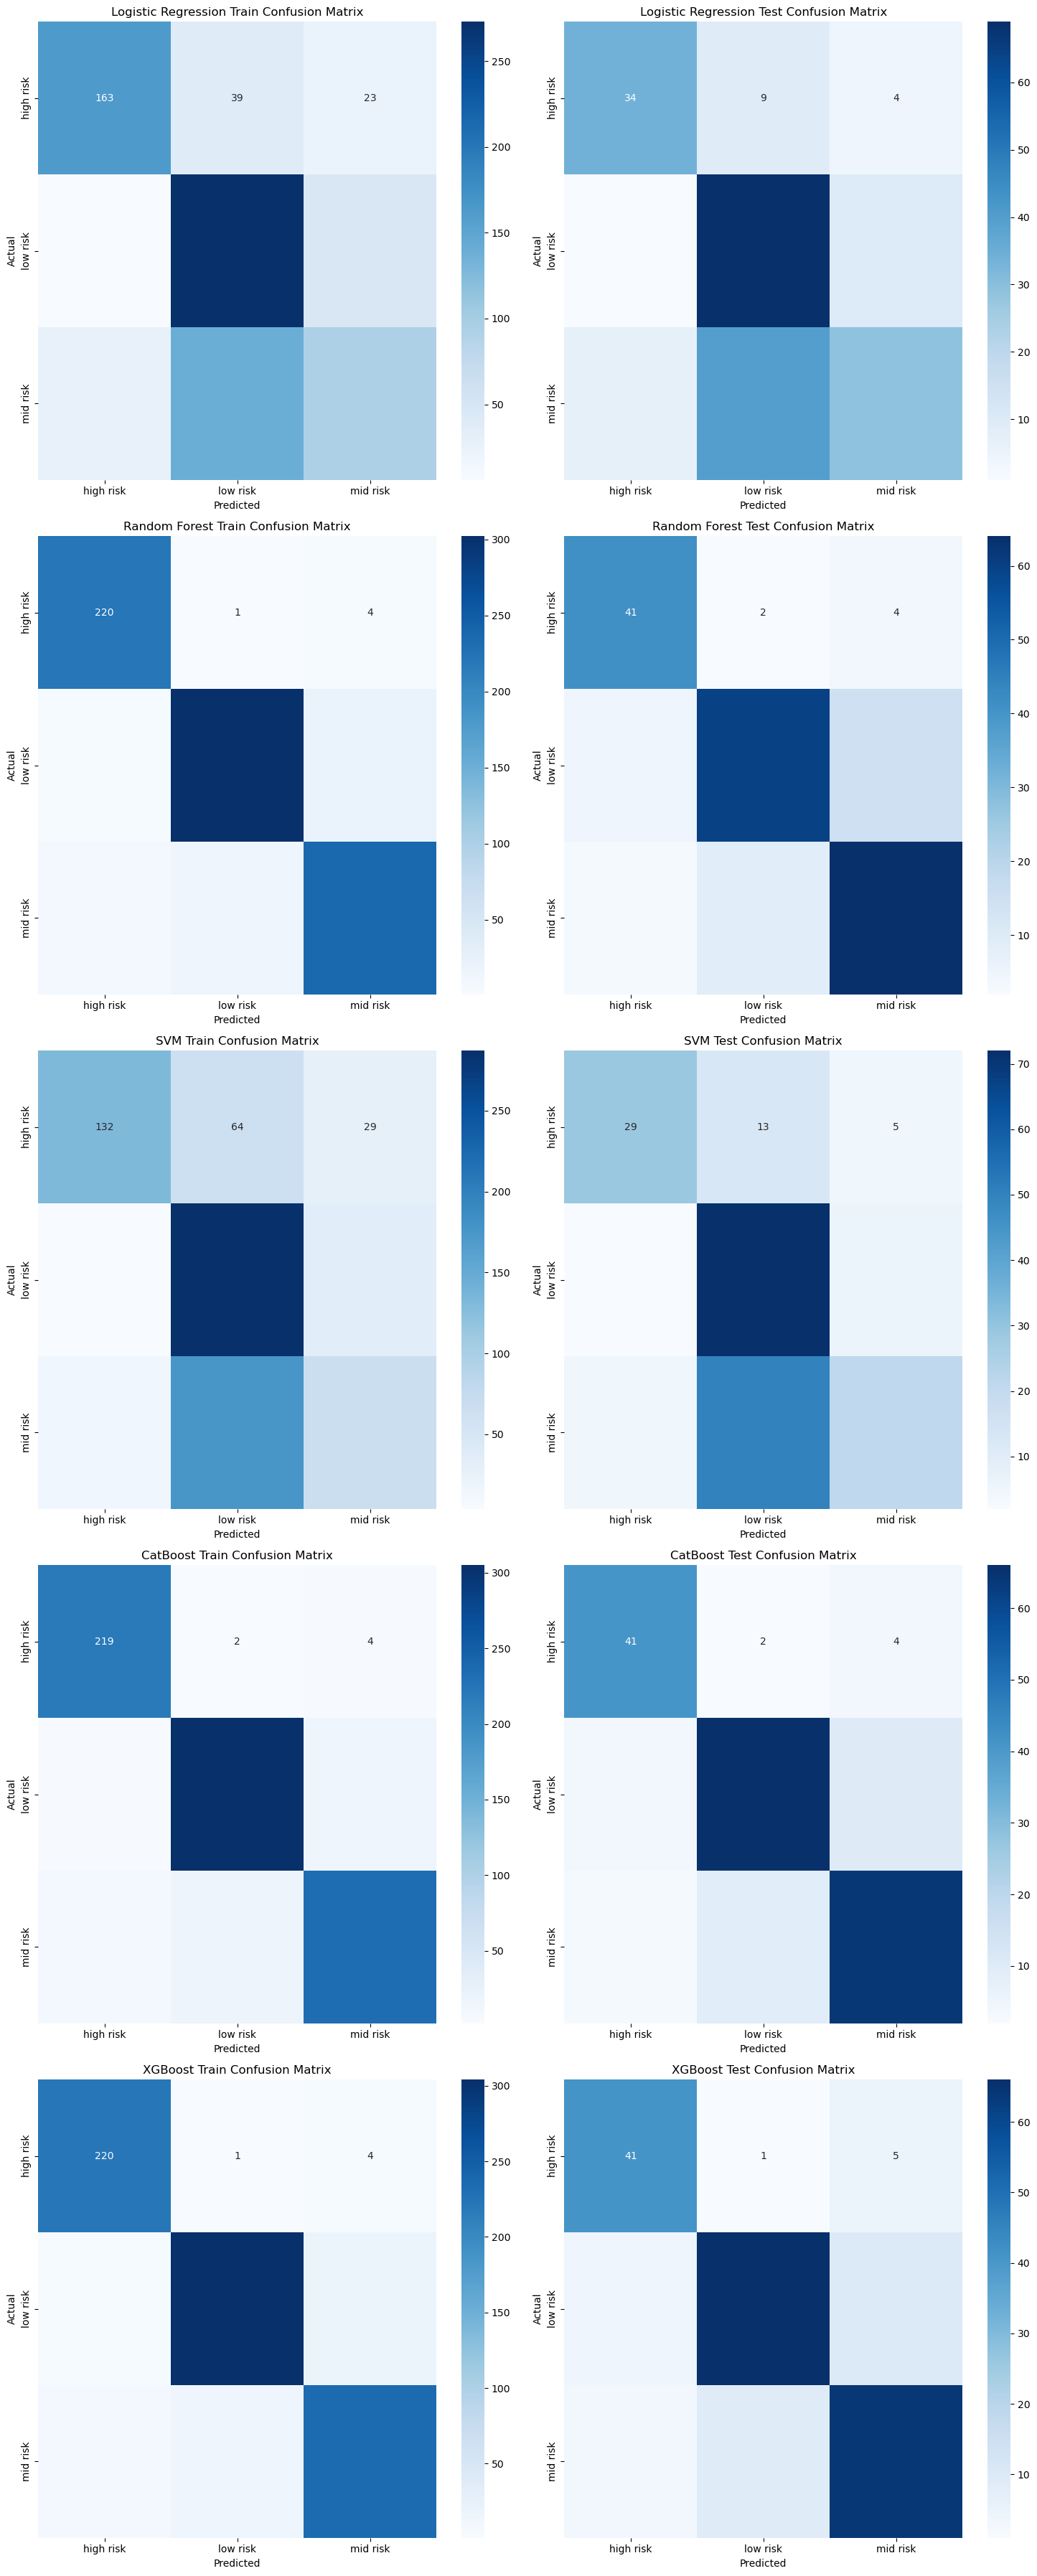

In [44]:
# Построить матрицы ошибок
fig, axes = plt.subplots(5, 2, figsize=(15, 36))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['train_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[idx * 2].set_title(f'{name} Train Confusion Matrix')
    axes[idx * 2].set_xlabel('Predicted')
    axes[idx * 2].set_ylabel('Actual')
    
    sns.heatmap(result['test_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2 + 1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[idx * 2 + 1].set_title(f'{name} Test Confusion Matrix')
    axes[idx * 2 + 1].set_xlabel('Predicted')
    axes[idx * 2 + 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


classification_reports = {name: {'train': result['train_report'], 'test': result['test_report']} for name, result in results.items()}
reports_df = pd.DataFrame(classification_reports)

In [46]:
print(f'Логистическая регрессия - тестовая матрица неточностей:\n{test_matrix}')

Логистическая регрессия - тестовая матрица неточностей:
[[41  1  5]
 [ 4 66 10]
 [ 3  9 64]]


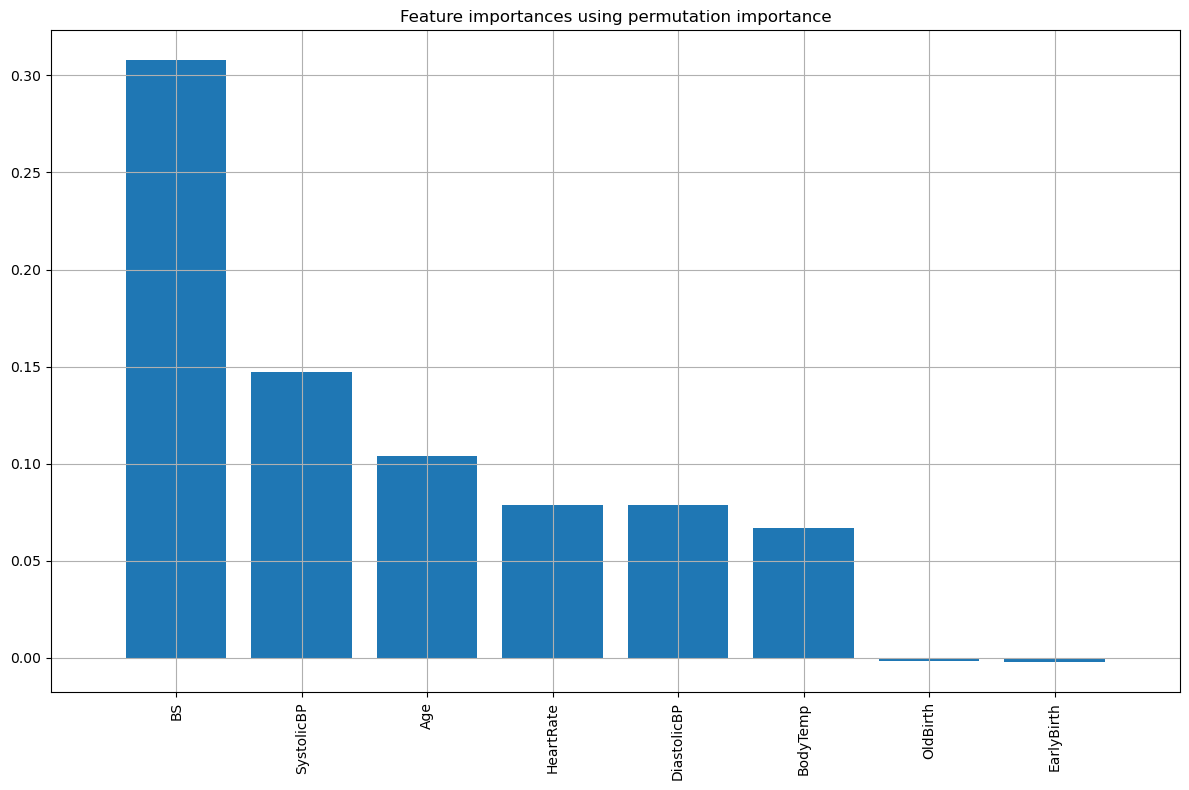

Best model: CatBoost with accuracy 0.84


In [22]:
# Выбрать лучшую модель по аккураси
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']

perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# Посмотрим на важность признаков
feature_names = X.columns
importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances using permutation importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.grid()
plt.show()

print(f"Best model: {best_model_name} with accuracy {results[best_model_name]['test_accuracy']:.2f}")


In [24]:
#Как мы видим - уровень сахара это наиболее значимая фича наряду с давлением которая оказывает влияние на целевую переменную

In [45]:
#Датафрейм со всеми метриками для более подробного изучения
reports_df

,Logistic Regression,Random Forest,SVM,CatBoost,XGBoost
train,"{0: {'precision': 0.7370892018779343, 'recall'...","{0: {'precision': 0.948051948051948, 'recall':...","{0: {'precision': 0.8584070796460177, 'recall'...","{0: {'precision': 0.9439655172413793, 'recall'...","{0: {'precision': 0.944206008583691, 'recall':..."
test,"{0: {'precision': 0.6666666666666666, 'recall'...","{0: {'precision': 0.851063829787234, 'recall':...","{0: {'precision': 0.82, 'recall': 0.8723404255...","{0: {'precision': 0.8541666666666666, 'recall'...","{0: {'precision': 0.8541666666666666, 'recall'..."


In [ ]:
# Определение функции для оптимизации и использование лучшей модели (в данном случае по Accuracy XGBoost)
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': len(set(y_train)),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Создание исследования и запуск оптимизации с прогресс-баром
study = optuna.create_study(direction='maximize', sampler=TPESampler())
n_trials = 1000

with tqdm(total=n_trials) as pbar:
    def objective_with_callback(trial):
        result = objective(trial)
        pbar.update(1)
        return result

    study.optimize(objective_with_callback, n_trials=n_trials)

# Вывод лучших гиперпараметров и точности
print(f'Лучшие гиперпараметры: {study.best_params}')
print(f'Лучший результат точности: {study.best_value:.4f}')

# Обучение модели с лучшими гиперпараметрами
best_params = study.best_params
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
best_model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность на тестовой выборке: {accuracy:.4f}')

[I 2024-06-10 11:24:17,322] A new study created in memory with name: no-name-4222f6b9-d088-4787-bf15-640fb462b37b


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/b9/9j4rxldd0d5fzcjyzp81fwzw0000gn/T/ipykernel_22919/3328255809.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/var/folders/b9/9j4rxldd0d5fzcjyzp81fwzw0000gn/T/ipykernel_22919/3328255809.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/var/folders/b9/9j4rxldd0d5fzcjyzp81fwzw0000gn/T/ipykernel_22919/3328255809.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_un

In [ ]:
# Выйгрыш в качестве - 0.0024  (0.8424)

Как улучшить модель :



1.   Feature Engeneering ( создать новые признаки - от комбинаций текущих до простых функций от них по типу логарифма и так далее )
2.   Попробовать Стекинг и Блендинг ( для этой задачи это оверкилл )
3. Покрутить параметры в Оптуне подольше и поменять границы



In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

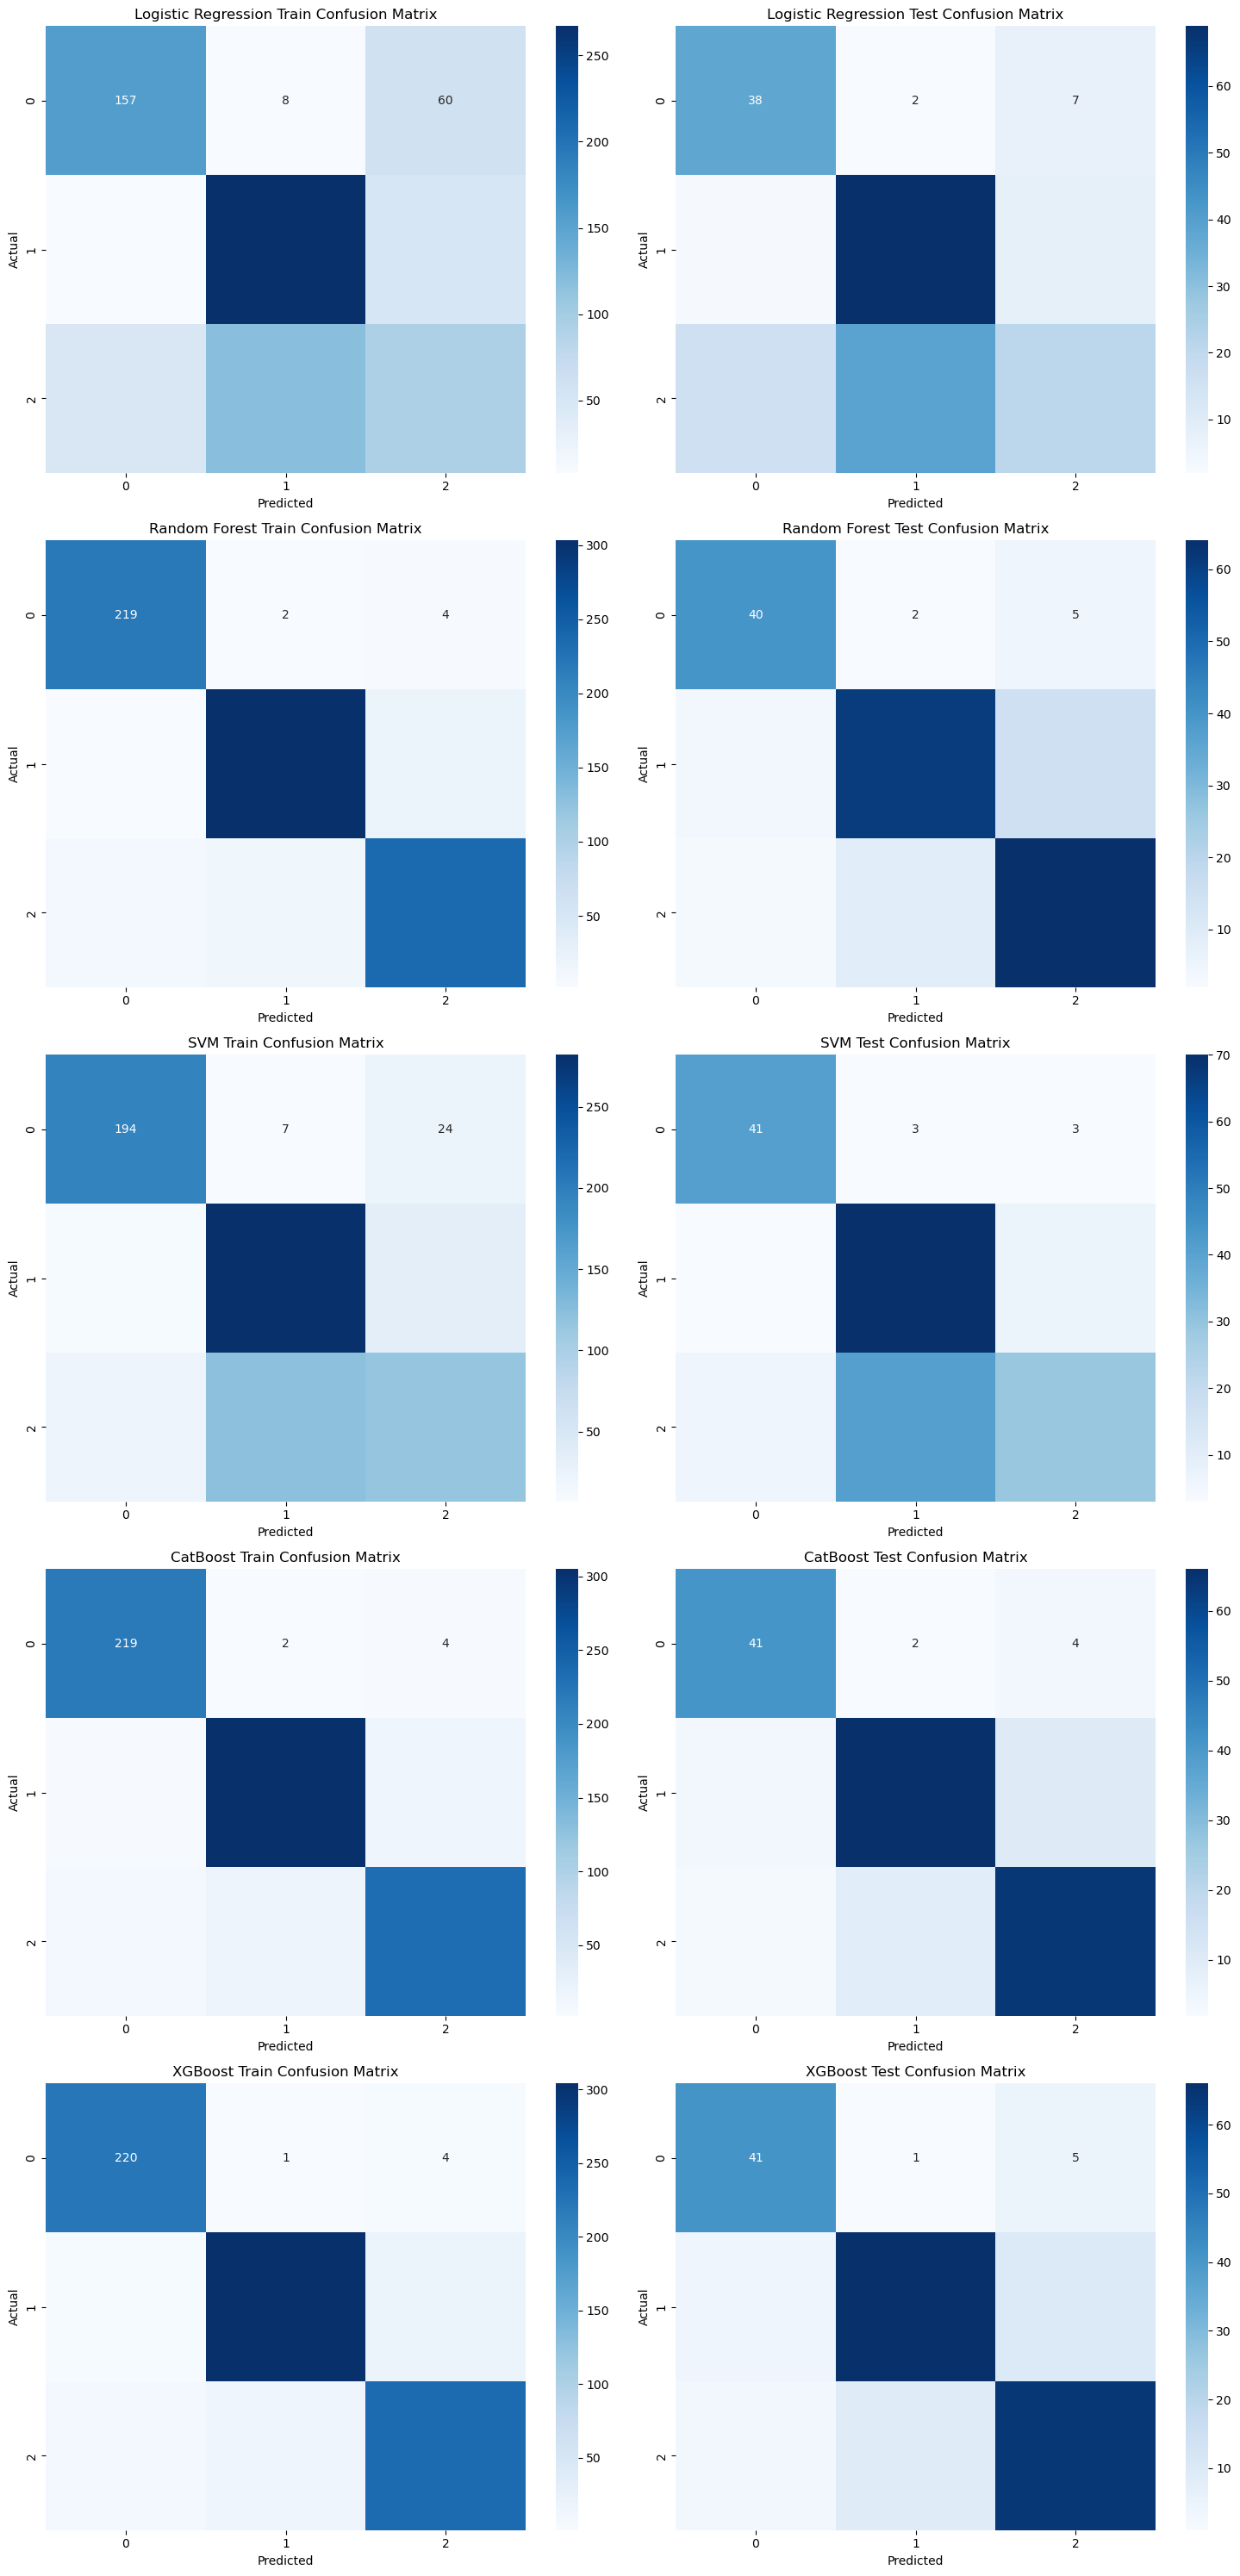

                                     Logistic Regression  \
train  {0: {'precision': 0.7370892018779343, 'recall'...   
test   {0: {'precision': 0.6666666666666666, 'recall'...   

                                           Random Forest  \
train  {0: {'precision': 0.948051948051948, 'recall':...   
test   {0: {'precision': 0.851063829787234, 'recall':...   

                                                     SVM  \
train  {0: {'precision': 0.8584070796460177, 'recall'...   
test   {0: {'precision': 0.82, 'recall': 0.8723404255...   

                                                CatBoost  \
train  {0: {'precision': 0.9439655172413793, 'recall'...   
test   {0: {'precision': 0.8541666666666666, 'recall'...   

                                                 XGBoost  
train  {0: {'precision': 0.944206008583691, 'recall':...  
test   {0: {'precision': 0.8541666666666666, 'recall'...  


In [34]:
# Разделить на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем все модели
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {}
label_encoder = LabelEncoder().fit(y)
all_labels = label_encoder.classes_

for name, model in models.items():
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    train_report = classification_report(y_train, y_train_pred, target_names=all_labels, output_dict=True)
    train_matrix = confusion_matrix(y_train, y_train_pred, labels=all_labels)
    
    test_report = classification_report(y_test, y_test_pred, target_names=all_labels, output_dict=True)
    test_matrix = confusion_matrix(y_test, y_test_pred, labels=all_labels)

    results[name] = {
        'model': model,
        'train_report': train_report,
        'train_matrix': train_matrix,
        'test_report': test_report,
        'test_matrix': test_matrix,
        'test_accuracy': accuracy_score(y_test, y_test_pred)
    }

# Построить матрицы ошибок
fig, axes = plt.subplots(len(results), 2, figsize=(15, len(results) * 6))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['train_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2],
                xticklabels=all_labels, yticklabels=all_labels)
    axes[idx * 2].set_title(f'{name} Train Confusion Matrix')
    axes[idx * 2].set_xlabel('Predicted')
    axes[idx * 2].set_ylabel('Actual')

    sns.heatmap(result['test_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx * 2 + 1],
                xticklabels=all_labels, yticklabels=all_labels)
    axes[idx * 2 + 1].set_title(f'{name} Test Confusion Matrix')
    axes[idx * 2 + 1].set_xlabel('Predicted')
    axes[idx * 2 + 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Создание отчета по классификации
classification_reports = {name: {'train': result['train_report'], 'test': result['test_report']} for name, result in results.items()}
reports_df = pd.DataFrame(classification_reports)
print(reports_df)